In [81]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import scale,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.decomposition import PCA
import os 

def plot_feature_importance(model,df):
    # Get feature importances
    feature_importances = model.feature_importances_

    # Associate feature importances with feature names
    feature_names = df.columns.values[:-1]
    feature_importance_dict = dict(zip(feature_names, feature_importances))

    # Print feature importance scores
    for feature, importance in feature_importance_dict.items():
        print(f"{feature}: {importance:.4f}")

    # Plot feature importances
    plt.figure(figsize=(8, 6))
    plt.bar(feature_importance_dict.keys(), feature_importance_dict.values())
    plt.xticks(rotation=45)
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.title("Feature Importance from Random Forest")
    plt.tight_layout()
    plt.show()

def get_abs(y,y_pred):
    return abs(y-y_pred)


def get_starting_idx(df):
    
    df['10_temp_diff'] = df['temperature'] - df['temperature'].shift(-10)

    df['temp_diff'] =  df['temperature'] - df['temperature'].shift(-1)

    for (idx, temp_diff) in enumerate(df['10_temp_diff']):

        if abs(temp_diff) >=1.5:

            new_df = df.iloc[idx:]

            return new_df[['temperature','date','Preproduct','Feed','Drilling Depth','10_temp_diff','temp_diff','RPM','audio']].dropna()
        
    return pd.DataFrame()
    

def separate_layers(start_df):

            
    try:

        layer1_thickness = int(start_df['Preproduct'].to_list()[0].split('_')[0].split('x')[-1])
        layer2_thickness = int(start_df['Preproduct'].to_list()[0].split('_')[1].split('x')[-1])
        layer3_thickness = int(start_df['Preproduct'].to_list()[0].split('_')[2].split('x')[-1])

        layer_1_duration = layer1_thickness/start_df['Feed'].iloc[0]
        layer_2_duration = layer2_thickness/start_df['Feed'].iloc[0]
        layer_3_duration = layer3_thickness/start_df['Feed'].iloc[0]
        
        
        
        layer_4_duration = (start_df['Drilling Depth'].iloc[0] - (layer1_thickness + layer2_thickness + layer3_thickness)) / start_df['Feed'].iloc[0] # I calculated the last thicknes and find the duration
        
        if layer_4_duration < 0:
            return pd.DataFrame()

        l1_dp = round(layer_1_duration * 10)
        l2_dp = round(layer_2_duration * 10)
        l3_dp = round(layer_3_duration * 10)
        l4_dp = round(layer_4_duration * 10)
        
        
        
        
        l1 = ['layer1' for _ in range(l1_dp)]
        l2 = ['layer2' for _ in range(l2_dp)]
        l3=  ['layer3' for _ in range(l3_dp)]
        l4 = ['layer4' for _ in range(l4_dp)]

        l = l1 + l2 + l3 + l4

        layers_DF = pd.DataFrame({'layers':l}) # this will give all the output of the layer separation
        
        start_df = pd.concat([start_df.reset_index(),layers_DF],axis=1)
        
        start_df = start_df.dropna()


        return start_df[['temperature','date','Preproduct','Feed','Drilling Depth','10_temp_diff','temp_diff','layers','RPM','audio']]
    
    except Exception as e:
        print("error {} when processing layers...skipping...".format(str(e)))

        return pd.DataFrame()

        

def separate_product(df):
    
    l1,l2,l3,l4 = df['Preproduct'].iloc[0].split('_')

    l1_df = df[df['layers']=='layer1'][['temperature','date','Feed','Drilling Depth','10_temp_diff','temp_diff','layers','RPM','audio']]
    l2_df = df[df['layers']=='layer2'][['temperature','date','Feed','Drilling Depth','10_temp_diff','temp_diff','layers','RPM','audio']]
    
    l3_df = df[df['layers']=='layer3'][['temperature','date','Feed','Drilling Depth','10_temp_diff','temp_diff','layers','RPM','audio']]
    l4_df = df[df['layers']=='layer4'][['temperature','date','Feed','Drilling Depth','10_temp_diff','temp_diff','layers','RPM','audio']]
    
    l1_df['Preproduct'] = l1
    l2_df['Preproduct'] = l2
    l3_df['Preproduct'] = l3
    l4_df['Preproduct'] = l4
    
    new_df = pd.concat([l1_df,l2_df,l3_df,l4_df],axis=0)

    return new_df




def process_whole_data(folder_path,files):
    all_df = pd.DataFrame(data=None)
    sep_layers = []

    for file in files:
        
        try:

            file_folder = os.path.join(folder_path,file)

            df_cfg = pd.read_csv(os.path.join(file_folder,'config.csv'))
            df = pd.read_parquet(os.path.join(file_folder,'data.parquet'))
            
            
            df['Preproduct'] = df_cfg['Preproduct'].values[0]

            df['Feed'] = df_cfg['Feed'].values[0]
            df['Drilling Depth'] = df_cfg['Drilling Depth'].values[0]
            
            df['RPM'] = df_cfg['RPM'].values[0]
            df['audio'] = df['audio'].shift(-1)
            df = df[['temperature','date','Preproduct','Feed','Drilling Depth','RPM','audio']]
            df = df.dropna()
            
            
            if len(df) > 0:
                new_df = get_starting_idx(df)
                
                if len(new_df) > 0:
                    
                    new_df = separate_layers(new_df)

                    if len(new_df) > 0:
                        new_df = separate_product(new_df)
                        
                        all_df = pd.concat([all_df,new_df],axis=0)
                        sep_layers.append(file)
                        
        
        except Exception as e:
            
            print("error {} processing file. skipping...".format(e))

    return all_df,sep_layers
        

def gen_label(df):
    labels = []

    for i in range(len(df)):
        d, t = df.iloc[i]['Preproduct'].split("x")

        if d!='spong':
            get = d.split(',')
            if len(get) > 1:
                labels.append(0.54)
            elif int(get[0])==50:
                labels.append(0.40)
            elif int(get[0])==35:
                labels.append(0.29)
            elif int(get[0])==30:
                labels.append(0.25)
            elif int(get[0])==20:
                labels.append(0.22)
            elif int(get[0])==15:
                labels.append(0.19)
        else:
            labels.append(0.60)

    return df, labels

In [43]:
train_path = 'train_data'
train_df = pd.DataFrame()

for file in os.listdir(train_path):
    df = pd.read_csv(os.path.join(train_path,file)).drop("Unnamed: 0",axis=1)
    train_df = pd.concat([train_df,df],axis=0).reset_index(drop=True)

In [46]:
train_audio = train_df['audio'].apply(lambda x: ast.literal_eval(x[2:-1]))

maxlen = np.max(train_audio.apply(len))
audio_padded= train_audio.apply(lambda x: np.pad(x, (0, maxlen - len(x)), mode='constant'))
train_audio_2d = np.vstack(audio_padded.values)

In [47]:
pca = PCA(n_components=5)

In [48]:
new_train_audio = pca.fit_transform(train_audio_2d)

In [49]:
label = gen_label(train_df)
train_df['label'] = label[-1]

In [50]:
to_train = train_df.drop(['10_temp_diff','Preproduct','layers','audio'],axis=1)
train_dt=pd.to_datetime(to_train['date'])

In [51]:
#to_train['hour'] = train_dt.dt.hour
to_train['minute'] = train_dt.dt.minute
to_train['second'] = train_dt.dt.second
to_train = to_train.drop(['date'],axis=1)

In [52]:
train_x = to_train.drop(['label'],axis=1).values
train_y = to_train['label'].values

In [53]:
#                                THIS WILL ADD SOUND TO DATA
new_train_x = np.hstack([train_x,new_train_audio])

#                                THIS WILL SCALE DATA
scaler = MinMaxScaler()
new_train_x = scaler.fit_transform(new_train_x)

In [54]:
rf_model = RandomForestRegressor()
rf_model.fit(new_train_x,train_y)

RandomForestRegressor()

In [55]:
import random
import pandas as pd

train_path = 'train_data'
test_path = 'test_data'
val_path = 'val_data'

train_data = os.listdir('train_data')
test_data = os.listdir('test_data')
val_data = os.listdir('val_data')

In [56]:
train_randn1 = random.randint(0,len(train_data)-1)
test_randn1 = random.randint(0,len(test_data)-1)
val_randn1 = random.randint(0,len(val_data)-1)

In [57]:
single_train1 = pd.read_csv(os.path.join(train_path,train_data[train_randn1])).drop("Unnamed: 0",1)
single_test1 = pd.read_csv(os.path.join(test_path,test_data[test_randn1])).drop("Unnamed: 0",1)
single_val1 = pd.read_csv(os.path.join(val_path,val_data[val_randn1])).drop("Unnamed: 0",1)

/tmp/ipykernel_15339/2529396394.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  single_train1 = pd.read_csv(os.path.join(train_path,train_data[train_randn1])).drop("Unnamed: 0",1)
/tmp/ipykernel_15339/2529396394.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  single_test1 = pd.read_csv(os.path.join(test_path,test_data[test_randn1])).drop("Unnamed: 0",1)
/tmp/ipykernel_15339/2529396394.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  single_val1 = pd.read_csv(os.path.join(val_path,val_data[val_randn1])).drop("Unnamed: 0",1)


In [58]:
def find_last_index(x):
    edge_indices = []
    current_value = None
    
    for i in range(len(x) - 1, -1, -1):
        if x[i] != current_value:
            edge_indices.append(i)
            current_value = x[i]
    
    return edge_indices[::-1]

def process_for_inference(single_train):
    single_train_audio = single_train['audio'].apply(lambda x: ast.literal_eval(x[2:-1]))
    maxlen = np.max(single_train_audio.apply(len))

    audio_padded= single_train_audio.apply(lambda x: np.pad(x, (0, maxlen - len(x)), mode='constant'))
    single_train_audio_2d = np.vstack(audio_padded.values)
    new_single_train_audio = pca.transform(single_train_audio_2d)


    single_train_label = gen_label(single_train)
    single_train['label'] = single_train_label[-1]
    single_train_dt=pd.to_datetime(single_train['date'])

    #single_train['hour'] = single_train_dt.dt.hour
    single_train['minute'] = single_train_dt.dt.minute
    single_train['second'] = single_train_dt.dt.second

    #                                               DROP STRING OF DATE AFTER CONVERTING TO INTEGERS
    single_train = single_train.drop(['date','layers','audio','Preproduct','10_temp_diff'],axis=1)

    single_train_x = single_train.drop(['label'],axis=1).values
    single_train_y = single_train['label'].values 

    #                                THIS WILL ADD SOUND TO DATA
    new_single_train_x = np.hstack([single_train_x,new_single_train_audio])
    #                                THIS WILL SCALE DATA
    new_single_train_x = scaler.transform(new_single_train_x)

    return new_single_train_x,single_train_y, single_train_audio_2d, single_train_dt


In [59]:
train_x1, train_y1, train_audio1, train_dt1 = process_for_inference(single_train1)
test_x1, test_y1, test_audio1, test_dt1 = process_for_inference(single_test1) 
val_x1, val_y1, val_audio1, val_dt1 = process_for_inference(single_val1)

In [60]:
train_out1 = rf_model.predict(train_x1)
test_out1 = rf_model.predict(test_x1)
val_out1 = rf_model.predict(val_x1)

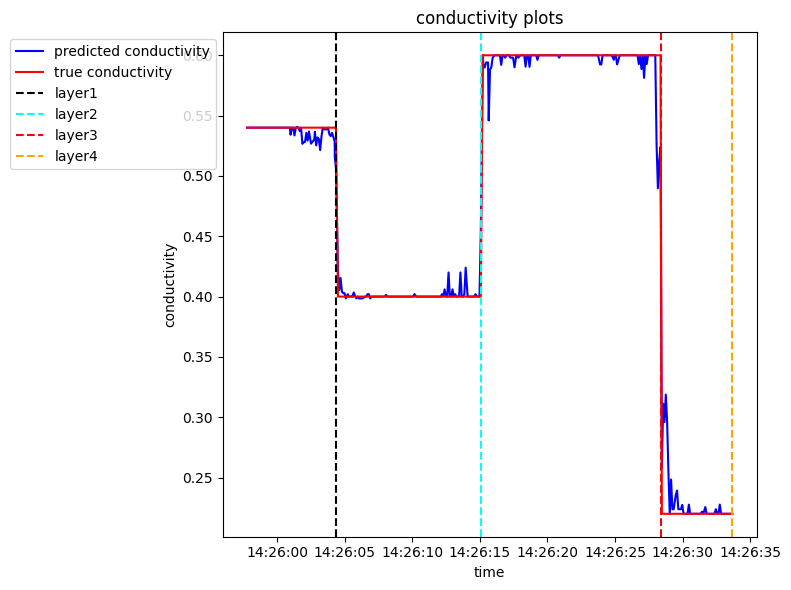

In [61]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(train_dt1,train_out1,label='predicted conductivity', color='blue')
ax.plot(train_dt1,train_y1,label='true conductivity',color='red')

out = find_last_index(train_y1)
ax.axvline(x=train_dt1[out[0]],color='black',linestyle='--', label='layer1')
ax.axvline(x=train_dt1[out[1]],color='cyan',linestyle='--', label='layer2')
ax.axvline(x=train_dt1[out[2]],color='red',linestyle='--', label='layer3')
ax.axvline(x=train_dt1[out[3]],color='orange',linestyle='--', label='layer4')

# Add labels and title
plt.ylabel("conductivity")
plt.xlabel('time')
plt.title("conductivity plots")

plt.legend(loc='upper right', bbox_to_anchor=(0.0, 1.0))
plt.tight_layout()
plt.show()


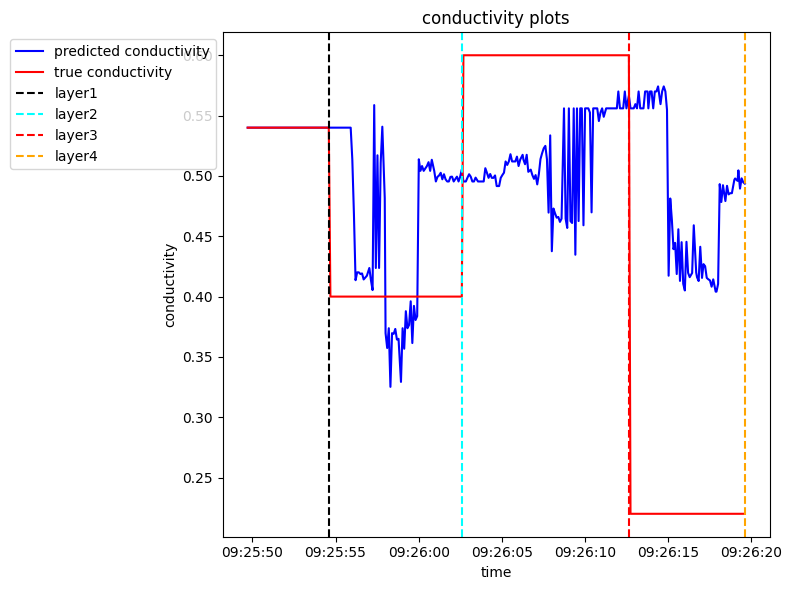

In [62]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(test_dt1,test_out1,label='predicted conductivity', color='blue')
ax.plot(test_dt1,test_y1,label='true conductivity',color='red')

out = find_last_index(test_y1)
ax.axvline(x=test_dt1[out[0]],color='black',linestyle='--', label='layer1')
ax.axvline(x=test_dt1[out[1]],color='cyan',linestyle='--', label='layer2')
ax.axvline(x=test_dt1[out[2]],color='red',linestyle='--', label='layer3')
ax.axvline(x=test_dt1[out[3]],color='orange',linestyle='--', label='layer4')

# Add labels and title
plt.ylabel("conductivity")
plt.xlabel('time')
plt.title("conductivity plots")

plt.legend(loc='upper right', bbox_to_anchor=(0.0, 1.0))
plt.tight_layout()
plt.show()

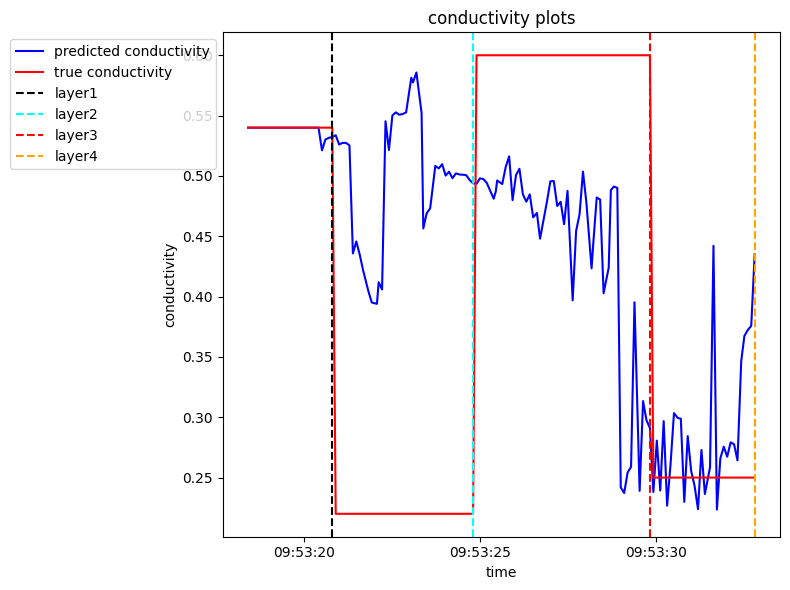

In [65]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(val_dt1,val_out1,label='predicted conductivity', color='blue')
ax.plot(val_dt1,val_y1,label='true conductivity',color='red')

out = find_last_index(val_y1)
ax.axvline(x=val_dt1[out[0]],color='black',linestyle='--', label='layer1')
ax.axvline(x=val_dt1[out[1]],color='cyan',linestyle='--', label='layer2')
ax.axvline(x=val_dt1[out[2]],color='red',linestyle='--', label='layer3')
ax.axvline(x=val_dt1[out[3]],color='orange',linestyle='--', label='layer4')

# Add labels and title
plt.ylabel("conductivity")
plt.xlabel('time')
plt.title("conductivity plots")

plt.legend(loc='upper right', bbox_to_anchor=(0.0, 1.0))
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


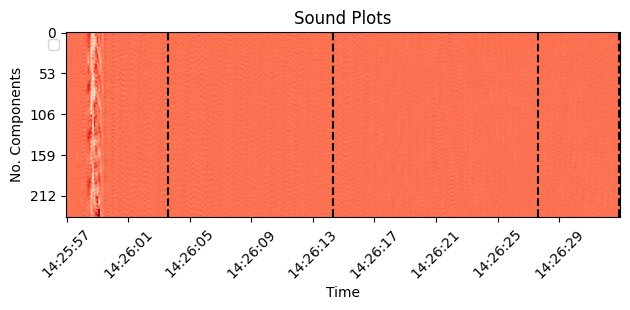

In [67]:
#                                                       TRAINING PLOT WITH TRANSITIONS

out = find_last_index(train_y1)
fig, ax = plt.subplots()
im = ax.imshow(train_audio1.T,cmap='Reds',aspect=0.5)

ax.axvline(x=out[0],color='black',linestyle='--')
ax.axvline(x=out[1],color='black',linestyle='--')
ax.axvline(x=out[2],color='black',linestyle='--')
ax.axvline(x=out[3],color='black',linestyle='--')

# Set the x-axis range to be in the 'sound_dt' time axis
x_ticks = range(len(train_dt1))
x_labels = [dt.strftime('%H:%M:%S') for dt in train_dt1]

# Add labels and title
plt.ylabel("No. Components")
plt.xlabel('Time')
plt.title("Sound Plots")

# Set the x-axis ticks and labels
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels, rotation=45)  # You can adjust the rotation angle as needed

# Optionally, you can adjust the spacing between ticks for better readability
ax.xaxis.set_major_locator(plt.MaxNLocator(10))

# Set the y-axis range and labels (adjust as needed)
y_ticks = np.arange(0, len(train_audio1.T), 53)
y_labels = y_ticks
# Set the y-axis ticks and labels
ax.set_yticks(y_ticks)

plt.legend(loc='upper right', bbox_to_anchor=(0.0, 1.0))
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


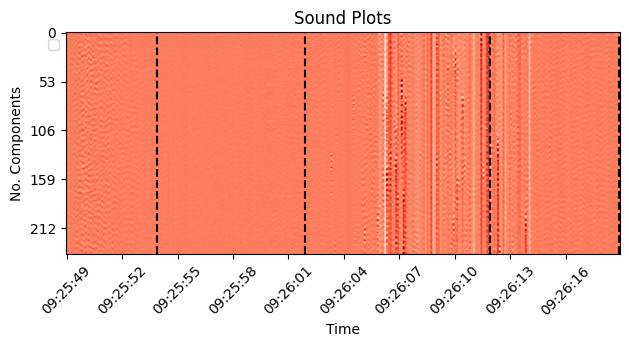

In [68]:
#                                                       TESTING PLOT WITH TRANSITIONS

out = find_last_index(test_y1)
fig, ax = plt.subplots()
im = ax.imshow(test_audio1.T,cmap='Reds',aspect=0.5)

ax.axvline(x=out[0],color='black',linestyle='--')
ax.axvline(x=out[1],color='black',linestyle='--')
ax.axvline(x=out[2],color='black',linestyle='--')
ax.axvline(x=out[3],color='black',linestyle='--')

# Set the x-axis range to be in the 'sound_dt' time axis
x_ticks = range(len(test_dt1))
x_labels = [dt.strftime('%H:%M:%S') for dt in test_dt1]

# Add labels and title
plt.ylabel("No. Components")
plt.xlabel('Time')
plt.title("Sound Plots")

# Set the x-axis ticks and labels
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels, rotation=45)  # You can adjust the rotation angle as needed

# Optionally, you can adjust the spacing between ticks for better readability
ax.xaxis.set_major_locator(plt.MaxNLocator(10))

# Set the y-axis range and labels (adjust as needed)
y_ticks = np.arange(0, len(test_audio1.T), 53)
y_labels = y_ticks
# Set the y-axis ticks and labels
ax.set_yticks(y_ticks)

plt.legend(loc='upper right', bbox_to_anchor=(0.0, 1.0))
plt.tight_layout()
plt.show()

In [69]:
train1_df = single_train1.copy()
test1_df = single_test1.copy()
val1_df = single_val1.copy()

In [70]:
train1_t = train1_df['Preproduct'].apply(lambda x: int(x.split('x')[-1]))
test1_t = test1_df['Preproduct'].apply(lambda x: int(x.split('x')[-1]))
val1_t = val1_df['Preproduct'].apply(lambda x: int(x.split('x')[-1]))

In [71]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train1_labels = label_encoder.fit_transform(train1_df['layers'])
test1_labels = label_encoder.transform(test1_df['layers'])
val1_labels = label_encoder.transform(val1_df['layers'])

<Figure size 500x500 with 0 Axes>

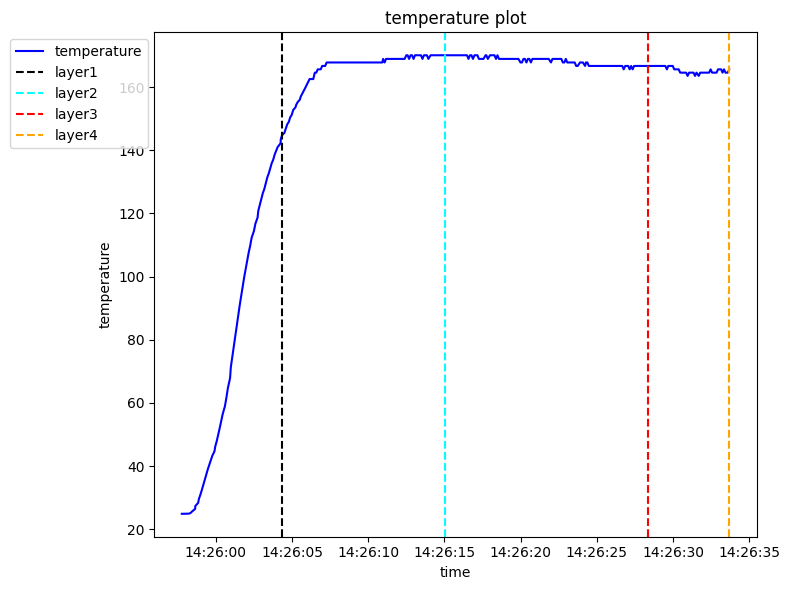

In [72]:
plt.figure(figsize=(5, 5))

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(train_dt1,train1_df['temperature'],label='temperature', color='blue')
out = find_last_index(train_y1)
ax.axvline(x=train_dt1[out[0]],color='black',linestyle='--', label='layer1')
ax.axvline(x=train_dt1[out[1]],color='cyan',linestyle='--', label='layer2')
ax.axvline(x=train_dt1[out[2]],color='red',linestyle='--', label='layer3')
ax.axvline(x=train_dt1[out[3]],color='orange',linestyle='--', label='layer4')

# Add labels and title
plt.ylabel("temperature")
plt.xlabel('time')
plt.title("temperature plot")

plt.legend(loc='upper right', bbox_to_anchor=(0.0, 1.0))
plt.tight_layout()
plt.show()


<Figure size 500x500 with 0 Axes>

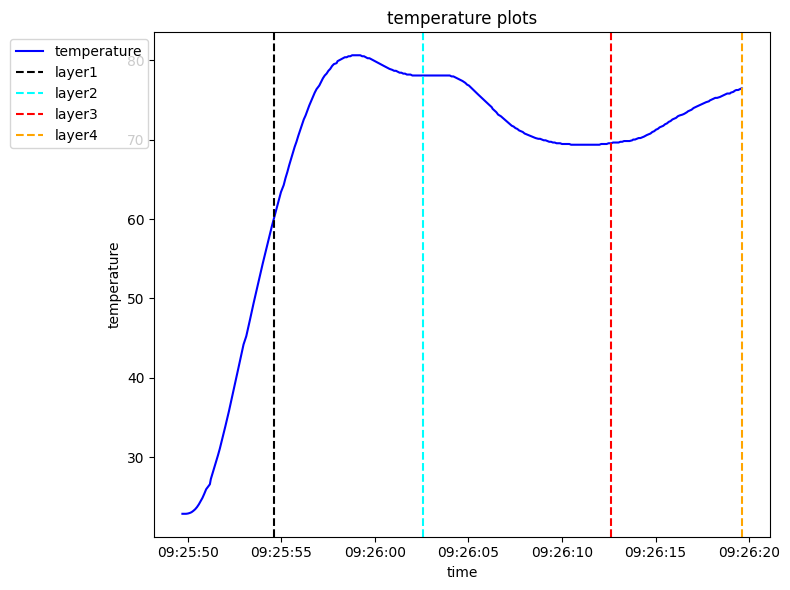

In [73]:
plt.figure(figsize=(5, 5))

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(test_dt1,test1_df['temperature'],label='temperature', color='blue')
out = find_last_index(test_y1)
ax.axvline(x=test_dt1[out[0]],color='black',linestyle='--', label='layer1')
ax.axvline(x=test_dt1[out[1]],color='cyan',linestyle='--', label='layer2')
ax.axvline(x=test_dt1[out[2]],color='red',linestyle='--', label='layer3')
ax.axvline(x=test_dt1[out[3]],color='orange',linestyle='--', label='layer4')

# Add labels and title
plt.ylabel("temperature")
plt.xlabel('time')
plt.title("temperature plots")

plt.legend(loc='upper right', bbox_to_anchor=(0.0, 1.0))
plt.tight_layout()
plt.show()


In [74]:
#                                                        ERROR PLOTTINGS
def abs_error(y,pred):
    y = np.array(y)
    pred = np.array(pred)
    dif = abs(y-pred)

    return dif

In [75]:
#                                                       TRAIN ERROR PLOTTINGS

<Figure size 500x500 with 0 Axes>

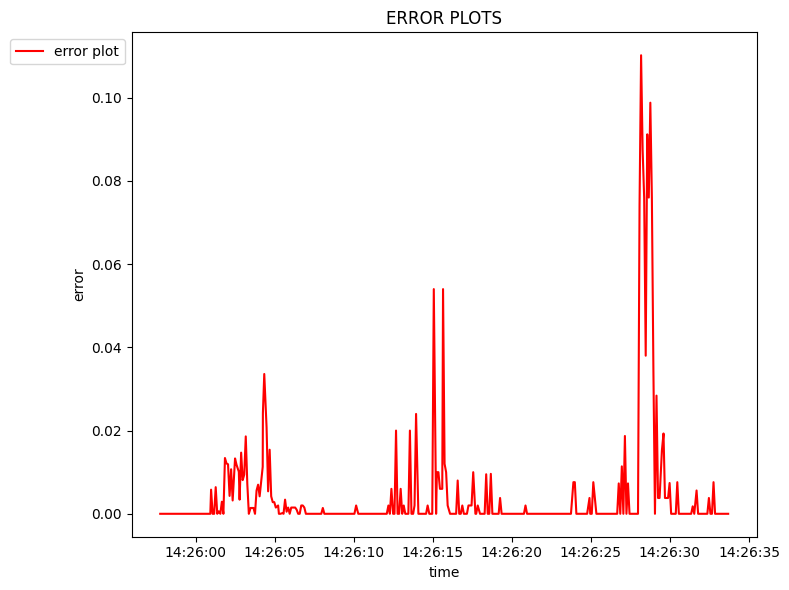

In [76]:
train1_error = abs_error(train_y1,train_out1)
plt.figure(figsize=(5, 5))

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(train_dt1,train1_error,color='red',label='error plot')

plt.ylabel("error")
plt.xlabel('time')
plt.title("ERROR PLOTS")

plt.legend(loc='upper right', bbox_to_anchor=(0.0, 1.0))
plt.tight_layout()
plt.show()

In [79]:
#                                                TESTING PLOT

<Figure size 500x500 with 0 Axes>

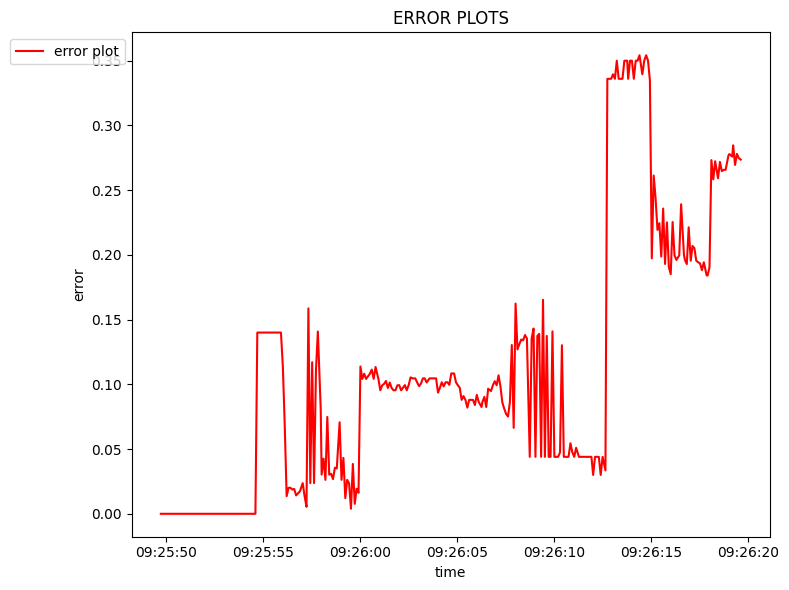

In [78]:
test1_error = abs_error(test_y1,test_out1)
plt.figure(figsize=(5, 5))

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(test_dt1,test1_error,color='red',label='error plot')

plt.ylabel("error")
plt.xlabel('time')
plt.title("ERROR PLOTS")

plt.legend(loc='upper right', bbox_to_anchor=(0.0, 1.0))
plt.tight_layout()
plt.show()

In [84]:
#                                                          ERROR METRICS

In [79]:
#                                                          Mean Absolute ERROR METRICS
train_mae = mean_absolute_error(train_y1,train_out1)
test_mae = mean_absolute_error(test_y1,test_out1)
val_mae = mean_absolute_error(val_y1,val_out1)


print("Train MAE: ",train_mae)
print("Test MAE: ",test_mae)
print("Val MAE: ",val_mae)

Train MAE:  0.004407222222222584
Test MAE:  0.11127633333333341
Val MAE:  0.1415310344827586


In [80]:
#                                                            Mean Squared Error Metrics
train_mse = mean_squared_error(train_y1,train_out1)
test_mse = mean_squared_error(test_y1,test_out1)
val_mse = mean_squared_error(val_y1,val_out1)

print("Train MSE: ",train_mse)
print("Test MSE: ",test_mse)
print("Val MSE: ",val_mse)

Train MSE:  0.00021837305555555335
Test MSE:  0.022403093100000025
Val MSE:  0.034085528827586205


In [82]:
#                                                             R2 score Metrics
train_r2 = r2_score(train_y1,train_out1)
test_r2 = r2_score(test_y1,test_out1)
val_r2 = r2_score(val_y1,val_out1)

print("Train R2 score: ",train_r2)
print("Test R2 score: ",test_r2)
print("val_r2 score: ",val_r2)

Train R2 score:  0.9877328632884372
Test R2 score:  -0.02503171211566735
val_r2 score:  -0.11349079575205301
